In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import sys
sys.path
sys.path.append('../')

# custom functs
from src.features import build_features
from src.visualization.visualize import plot_confusion_matrix
from src.utils.utils import get_project_root

In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

import random
from collections import Counter

from nltk import ngrams
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

## Prepare data

In [4]:
ROOT_PATH = get_project_root()
D1_PATH = ROOT_PATH / "data/raw/EmotionPush/emotionpush.augmented.json"

df = build_features.to_df(D1_PATH)

In [5]:
# simplify emotion labels
df = df[df.emotion2.isin(["neutral", "joy", "sadness", "anger"])]

## Feature transform (onehot)

In [6]:
tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

X = df.utterance2
freq = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words='english', lowercase=True)
X = freq.fit_transform(X)

onehot = Binarizer()
X = onehot.fit_transform(X.toarray())

## Stratified train test split

In [7]:
# X as is from above
y = df.emotion2

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y)

## Fit Model & predict

In [9]:
clf = LinearSVC(random_state=0)

In [10]:
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [11]:
# predict
y_pred = clf.predict(X_test)

## Eval predictions

Confusion matrix, without normalization
[[   5    7   15    1]
 [   0  268  150    2]
 [   3  107 1839   22]
 [   1    7   42   53]]


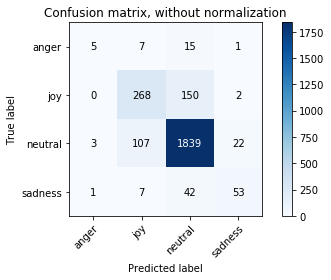

In [12]:
np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred,
                      title='Confusion matrix, without normalization')



plt.show()

Normalized confusion matrix
[[0.18 0.25 0.54 0.04]
 [0.   0.64 0.36 0.  ]
 [0.   0.05 0.93 0.01]
 [0.01 0.07 0.41 0.51]]


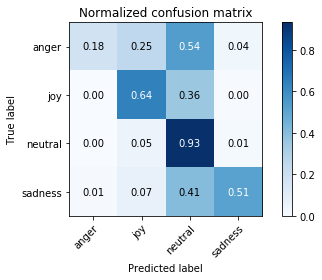

In [13]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Normalized confusion matrix')

In [14]:
def myscorer(y_test, y_pred):
    # micro average (precision, recall, f1) of anger, joy, sadness
    classes_names = ["anger", "joy", "neutral", "sadness"]
    
    angersum = len([ x for x in y_pred if x == "anger"])
    joysum = len([ x for x in y_pred if x == "joy"])
    sadsum = len([ x for x in y_pred if x == "sadness"])
    
    angertot = len([ x for x in y_test if x == "anger"])
    joytot = len([ x for x in y_test if x == "joy"])
    sadtot = len([ x for x in y_test if x == "sadness"])

    prec = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    print("Anger\t\t -> # pred: {}/{},\t prec: {:.3f}, recall: {:.3f}, f1: {:.3f}".format(
        angersum, angertot, prec[0], recall[0], f1[0]))
    print("Joy\t\t -> # pred: {}/{},\t prec: {:.3f}, recall: {:.3f}, f1: {:.3f}".format(
        joysum, joytot, prec[1], recall[1], f1[1]))
    print("Sadness\t\t -> # pred: {}/{},\t prec: {:.3f}, recall: {:.3f}, f1: {:.3f}".format(
        sadsum, sadtot, prec[3], recall[3], f1[3])) 
    print("Micro\t\t -> # pred: {}/{},\t prec: {:.3f}, recall: {:.3f}, f1: {:.3f}".format(
        angersum+joysum+sadsum, angertot+joytot+sadtot, (prec[0]+prec[1]+prec[3])/3, 
        (recall[0]+recall[1]+recall[3])/3,
        (f1[0]+f1[1]+f1[3])/3 ))

In [15]:
myscorer(y_test, y_pred)

Anger		 -> # pred: 9/28,	 prec: 0.556, recall: 0.179, f1: 0.270
Joy		 -> # pred: 389/420,	 prec: 0.689, recall: 0.638, f1: 0.663
Sadness		 -> # pred: 78/103,	 prec: 0.679, recall: 0.515, f1: 0.586
Micro		 -> # pred: 476/551,	 prec: 0.641, recall: 0.444, f1: 0.506
